In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("/content/empAttrition.csv")
df.head()

,Employee_ID,Age,Gender,Department,Job_Title,Years_at_Company,Satisfaction_Level,Average_Monthly_Hours,Promotion_Last_5Years,Salary,Attrition
0,0,27,Male,Marketing,Manager,9,0.586251,151,0,60132,0
1,1,53,Female,Sales,Engineer,10,0.261161,221,1,79947,0
2,2,59,Female,Marketing,Analyst,8,0.304382,184,0,46958,1
3,3,42,Female,Engineering,Manager,1,0.480779,242,0,40662,0
4,4,44,Female,Sales,Engineer,10,0.636244,229,1,74307,0


In [3]:
df = df.drop(["Employee_ID"],axis=1)

In [4]:
X = df.drop(["Attrition"],axis=1)
y = df["Attrition"]


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

numerical_features = X.select_dtypes(exclude="object").columns.tolist()
categorical_features = X.select_dtypes(include="object").columns.tolist()

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',numerical_transformer,numerical_features),
        ('cat', categorical_transformer,categorical_features)
    ]
)

In [6]:
X = preprocessor.fit_transform(X)

In [8]:
def conf_matrix(y_test, y_pred):
  con_metrix = confusion_matrix(y_test, y_pred)
  con_metrix = pd.DataFrame(con_metrix,range(2),range(2))

  plt.figure(figsize=(5,5))
  plt.title('Confution Matrix')
  sns.heatmap(con_metrix,annot=True,cbar=False,fmt='g')

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

0.44


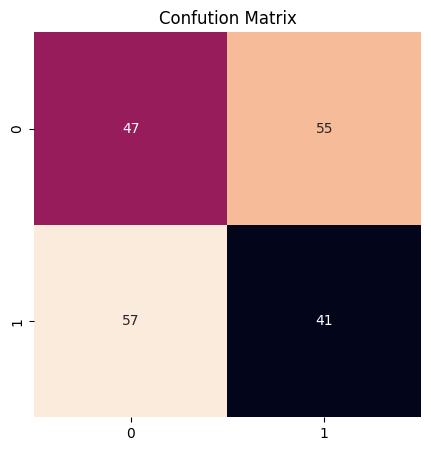

In [10]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

acc_lr = accuracy_score(y_test, lr_pred)
print(acc_lr)
conf_matrix(y_test, lr_pred)

0.435


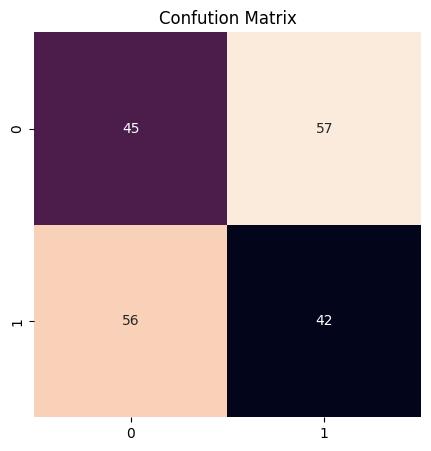

In [11]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

acc_rfc = accuracy_score(y_test, rfc_pred)
print(acc_rfc)
conf_matrix(y_test, rfc_pred)

0.48


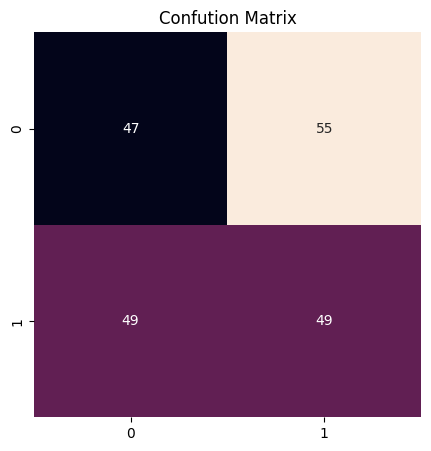

In [12]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

acc_knn = accuracy_score(y_test, knn_pred)
print(acc_knn)
conf_matrix(y_test, knn_pred)



0.5


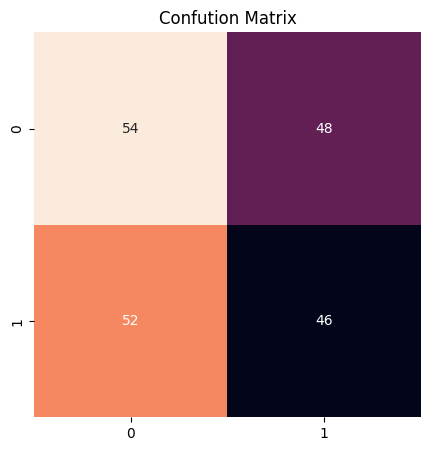

In [13]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, xgb_pred)
print(acc_xgb)
conf_matrix(y_test, xgb_pred)

0.425


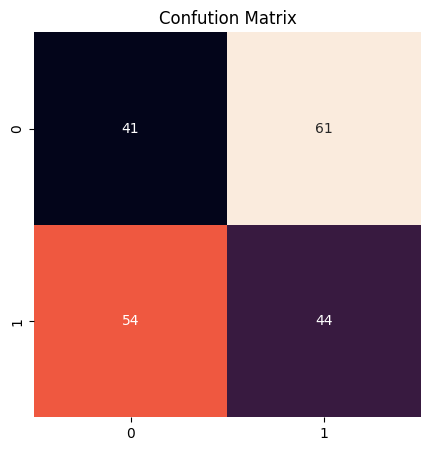

In [14]:
svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

acc_svm = accuracy_score(y_test, svm_pred)
print(acc_svm)
conf_matrix(y_test, svm_pred)

In [15]:
kf = StratifiedKFold(n_splits=5, shuffle=True)
xgb_classifier = XGBClassifier(max_depth=6, learning_rate =0.1, random_state=42)

In [16]:
score = cross_val_score(xgb_classifier,X_train,y_train,cv=kf, scoring = 'recall')
print("Cross validation recall scores are:{}".format(score))
print("Avarage cross validation recall score is: {}".format(score.mean()))

Cross validation recall scores are:[0.575      0.45       0.53164557 0.55696203 0.46835443]
Avarage cross validation recall score is: 0.5163924050632911


In [17]:
params = {
    'n_estimaters' : [10,20],
    'max_depth' :[4,5,6]
}
rand_xgb = RandomizedSearchCV(xgb_classifier,param_distributions=params,cv=kf,scoring='recall').fit(X_train,y_train)

In [18]:
print("Best Parameters:", rand_xgb.best_params_)
print("Best Score:", rand_xgb.best_score_)

Best Parameters: {'n_estimaters': 10, 'max_depth': 6}
Best Score: 0.5114873417721519


In [19]:
y_pred = rand_xgb.predict(X_test)

In [20]:
from sklearn.metrics import recall_score,precision_score

cm = confusion_matrix(y_test, y_pred)

xgb_f1 = f1_score(y_test, y_pred)
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_roc = roc_auc_score(y_test, y_pred)

print(cm)

[[47 55]
 [54 44]]


In [21]:
ndf = [(xgb_f1, xgb_accuracy, xgb_precision, xgb_recall, xgb_roc)]

xgb_score = pd.DataFrame(data=ndf, columns= ['xgb_f1','xgb_accuracy','xgb_precision','xgb_recall','xgb_roc'])
xgb_score.insert(0, 'XGB with', 'no under/over sampling')
xgb_score

,XGB with,xgb_f1,xgb_accuracy,xgb_precision,xgb_recall,xgb_roc
0,no under/over sampling,0.446701,0.455,0.444444,0.44898,0.454882


In [22]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_train, y_train)

In [23]:
from imblearn.pipeline import make_pipeline

random_overs_pipline = make_pipeline(RandomOverSampler(random_state=42),
                                     XGBClassifier(max_depth=6, learning_rate =0.1, random_state=42))

In [24]:
score2 = cross_val_score(random_overs_pipline,X_train,y_train,cv=kf,scoring='recall')
print("Cross validation recall scores are:{}".format(score2))
print("Avarage Cross validation recall score is:{}".format(score2.mean()))

Cross validation recall scores are:[0.425      0.525      0.46835443 0.4556962  0.58227848]
Avarage Cross validation recall score is:0.4912658227848102


In [25]:
new_params = {'xgbclassifier__'+ key:params[key] for key in params}

rand_over_xgb = RandomizedSearchCV(random_overs_pipline,param_distributions=new_params,cv=kf,scoring='recall',return_train_score=True)
rand_over_xgb.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=Pipeline(steps=[('randomoversampler',
                                              RandomOverSampler(random_state=42)),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enabl...
                                                            max_cat_to_onehot=None,
                                                            max_delta_step=None,
                                                            max_depth=6,
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   param_distributions={'xgbclassifier__max_depth': [4, 5, 6],
                                        'xgbclassifier__n_estimaters': [10,
                                                                        20]},
                   return_train_score=True, scoring='recall')

In [26]:
print("Best Parameter:", rand_over_xgb.best_params_)
print("best Score:", rand_over_xgb.best_score_)

Best Parameter: {'xgbclassifier__n_estimaters': 10, 'xgbclassifier__max_depth': 6}
best Score: 0.5390189873417721


In [27]:
y_pred = rand_over_xgb.best_estimator_.named_steps['xgbclassifier'].predict(X_test)

In [28]:
cm = confusion_matrix(y_test, y_pred)

xgb_over_f1 = f1_score(y_test, y_pred)
xgb_over_accuracy = accuracy_score(y_test,y_pred)
xgb_over_precision = precision_score(y_test, y_pred)
xgb_over_recall = recall_score(y_test, y_pred)
xgb_over_roc = roc_auc_score(y_test, y_pred)

print(cm)

[[57 45]
 [49 49]]


In [29]:
ndf = [(xgb_over_f1, xgb_over_accuracy, xgb_over_precision,xgb_over_recall,xgb_over_roc)]

xgb_over_score = pd.DataFrame(data=ndf, columns = ['xgb_f1','xgb_accuracy','xgb_precision','xgb_recall','xgb_roc'])
xgb_over_score.insert(0, 'XGB with','over sampling')
xgb_over_score

,XGB with,xgb_f1,xgb_accuracy,xgb_precision,xgb_recall,xgb_roc
0,over sampling,0.510417,0.53,0.521277,0.5,0.529412


In [30]:
from imblearn.under_sampling import TomekLinks
tomekU = TomekLinks()
X_tomek,y_tomek = tomekU.fit_resample(X_train, y_train)

In [31]:
from imblearn.combine import SMOTETomek
SmoteTomek_pipline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')),
                                   XGBClassifier(max_depth=6, lerning_rate=0.1,random_state=42 ))


In [32]:
SMOTETomek_xgb = SmoteTomek_pipline
SMOTETomek_xgb.fit(X_train, y_train)



Pipeline(steps=[('smotetomek',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               lerning_rate=0.1, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [33]:
y_pred = SMOTETomek_xgb.predict(X_test)

In [34]:
cm = confusion_matrix(y_test, y_pred)

xgb_smoteT_f1 = f1_score(y_test, y_pred)
xgb_smoteT_accuracy = accuracy_score(y_test,y_pred)
xgb_smoteT_precision = precision_score(y_test, y_pred)
xgb_smoteT_recall = recall_score(y_test, y_pred)
xgb_smoteT_roc = roc_auc_score(y_test, y_pred)

print(cm)

[[38 64]
 [38 60]]


In [35]:
ndf = [(xgb_smoteT_f1,xgb_smoteT_accuracy,xgb_smoteT_precision,xgb_smoteT_recall,xgb_smoteT_roc)]

SMOTETomek_xgb_score = pd.DataFrame(data=ndf,columns=['xgb_f1','xgb_accuracy','xgb_precision','xgb_recall','xgb_roc'])
SMOTETomek_xgb_score.insert(0,'XGB with','SMOTETomek')
SMOTETomek_xgb_score

,XGB with,xgb_f1,xgb_accuracy,xgb_precision,xgb_recall,xgb_roc
0,SMOTETomek,0.540541,0.49,0.483871,0.612245,0.492397


In [36]:
score2 = cross_val_score(random_overs_pipline,X_train,y_train,cv=kf,scoring='recall')
print("Cross validation recall scores are:{}".format(score2))
print("Avarage cross validation recall scores are: {}".format(score2.mean()))

Cross validation recall scores are:[0.4875     0.55       0.51898734 0.44303797 0.41772152]
Avarage cross validation recall scores are: 0.4834493670886076
